In [1]:
from os import listdir
from os.path import isfile, join
import os
import numpy
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import time
import glob
import pandas as pd

# input image dimensions
imgSize = [70,70]
input_shape = (imgSize[0],imgSize[1],1)
numpy.random.seed(123)  # for reproducibility

def load_train(img_path):
    # open images in one letter folder
    mypath=img_path
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    biasCount = 0
    for i in range(0, len(onlyfiles)):
        #dealing with .Dash_store
        if onlyfiles[i-biasCount][0] == '.':  
            del onlyfiles[i-biasCount]
            biasCount += 1
            print("after folders:",onlyfiles)
    images = numpy.empty([len(onlyfiles),imgSize[0],imgSize[1]], dtype=object)
    labels = numpy.empty(len(onlyfiles), dtype=object)
    print(images.shape)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(mypath,onlyfiles[n]) )
        img = cv2.resize(img,(imgSize[0], imgSize[1]))
        #convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply dilation and erosion to remove some noise
        kernel = numpy.ones((1, 1), numpy.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
        img = cv2.erode(img, kernel, iterations=1)
        
        images[n] = img
        # get the font names
        labels[n] = onlyfiles[n].split(".png")[0].split("-")[1].split("-")[0]
        
        if (n==0):
            plt.subplot(330 + (n+1))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            plt.title(labels[n])
            plt.savefig("test.png",bbox_inches='tight')
        
    return [images,labels]

In [2]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)

def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model

def process_income_image(input_data):
    input_data = numpy.array(input_data, dtype=numpy.float32)
    # train_data = train_data.transpose((0, 3, 1, 2))
    input_data = input_data.astype('float32')
    input_data /= 255
    print('Train shape:', input_data.shape)
    print(input_data.shape[0], 'train samples')
    input_data = input_data.reshape(input_data.shape[0],input_data.shape[1],input_data.shape[2],1)
    print(input_data.shape)
    return input_data

In [3]:
# load traing dataset

cache_path = os.path.join('cache', 'trainL_f1_220bg.dat')
if not os.path.isfile(cache_path):
    X_train, y_train = load_train('generated/220BG_f1')
    print(X_train.shape, y_train.shape)
    cache_data((X_train, y_train), cache_path)
    print("cache_data")
else:
    print('Restore train from cache!')
    (X_train, y_train) = restore_data(cache_path)
    print(X_train.shape, y_train.shape)

Restore train from cache!
(30708, 70, 70) (30708,)


In [4]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

#save the uncoded labels
labels_data = y_train
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

y_train = dummy_y
print(y_train.shape)

Using TensorFlow backend.


(30708, 39)


In [5]:
# preprocess training images

X_train = process_income_image(X_train)
imgTrain = X_train.reshape(X_train.shape[0], imgSize[0], imgSize[1])

Train shape: (30708, 70, 70)
30708 train samples
(30708, 70, 70, 1)


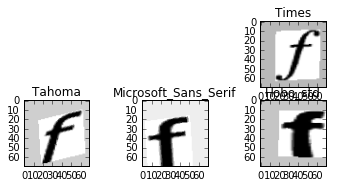

In [6]:
from sklearn.model_selection import train_test_split
# visually check

for i in range(5, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(imgTrain[i], cmap=plt.get_cmap('gray'))
    plt.title(labels_data[i])

In [8]:
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint, TensorBoard
from time import time
from datetime import datetime

filepath="backups/weights0810_f1.best.hdf5"#"backups/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

earlystopping = EarlyStopping(monitor='loss',patience=2,verbose=1)

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
tensorboard = TensorBoard("logs/run_0811_f1_7")

callbacks = [earlystopping, checkpoint, tensorboard]

In [9]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# generate more training images

def generatImage(img, label):
    datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            #zoom_range=0.2,
            zoom_range=[1.3,1.5],
            fill_mode="constant",
            cval=180,# 255
            channel_shift_range=90
            # horizontal_flip=True,
            )

    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    label = label + '-0'
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='generated/220BG_f1', save_prefix=label, save_format='png'):
        i += 1
        if i > 250:
            break  # otherwise the generator would loop indefinitely

In [11]:
def loadImageToGen(img_path):    
    mypath=img_path
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    print(onlyfiles)
    #.Dash_store
    if onlyfiles[0][0] == '.':  
        del onlyfiles[0]
        print(onlyfiles)
    images = numpy.empty([len(onlyfiles),imgSize[0],imgSize[1]], dtype=object)
    labels = numpy.empty(len(onlyfiles), dtype=object)
    print(images.shape)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(mypath,onlyfiles[n]) )
        img = cv2.resize(img,(imgSize[0], imgSize[1]))
        #convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply dilation and erosion to remove some noise
        kernel = numpy.ones((1, 1), numpy.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
        img = cv2.erode(img, kernel, iterations=1)
        
        images[n] = img
        labels[n] = onlyfiles[n].split(".png")[0]
        generatImage(img, labels[n])
        
        if (n==6):
            plt.subplot(330 + (n+1))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            plt.title(labels[n])
        
    return [images,labels]

# run this code to generate more images
# loadImageToGen('dataset/f1')

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [14]:
def my_custom5_cnn_model(kernelno):
    model = Sequential()
    #model.add(SpatialTransformer(localization_net=locnet, output_size=(80, 80), input_shape=input_shape))
    #model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,28,28)))
    model.add(Conv2D(kernelno, (3, 3), input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    print (model.output_shape)
    # (None, 26, 26, 32)
    model.add(Conv2D(kernelno, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(kernelno, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(kernelno, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    #model.add(Dropout(0.25))
    model.add(Conv2D(kernelno, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    print (model.output_shape)
    
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(39, activation='softmax'))

    # load weights
    # model.load_weights("backups/weights0810_f1.best.hdf5")
    
    from keras import optimizers
    ad10e4 = optimizers.Adam(lr=0.00005)
    #commpile model
    model.compile(optimizer=ad10e4,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

(30708, 70, 70, 1) (30708, 39) [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


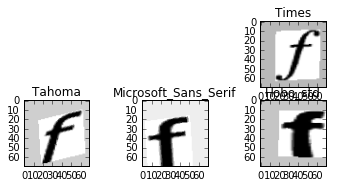

In [15]:
# # test and visualize data to check if there's some problem
print(X_train.shape, y_train.shape, y_train[0])

testTrain = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])        
for i in range(5, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(testTrain[i], cmap=plt.get_cmap('gray'))
    plt.title(labels_data[i])   

In [16]:
model = my_custom5_cnn_model(150)
model.summary()
#Fit keras Model
model.fit(X_train, y_train,
          batch_size=30, epochs=30, verbose=1, callbacks=callbacks, validation_split=0.01) #instead of 15epoch
# callbacks=callbacks,
# Epoch 1/10
# 7744/60000 [==>...........................] - ETA: 96s - loss: 0.5806 - acc: 0.8164

# score = model.evaluate(X_test, Y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print('training completed')

(None, 34, 34, 150)
(None, 3, 3, 150)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 150)       1500      
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 150)       600       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 150)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 150)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 150)       202650    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 150)       600       
_________________________________________________________________
activation_2 (Activation)    (None, 32

In [17]:
model.save('my_model_0811_f1_063.h5')

In [18]:
def load_test(img_path):
    # open images in one letter folder
    mypath=img_path
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    #.Dash_store
    biasCount = 0
    for i in range(0, len(onlyfiles)):
        if onlyfiles[i-biasCount][0] == '.':  
            del onlyfiles[i-biasCount]
            biasCount += 1
            print("after folders:",onlyfiles)
    images = numpy.empty([len(onlyfiles),imgSize[0],imgSize[1]], dtype=object)
    labels = numpy.empty(len(onlyfiles), dtype=object)
    labelsStr = numpy.empty(len(onlyfiles), dtype=object)
    print(images.shape)
    for n in range(0, len(onlyfiles)):
        img = cv2.imread( join(mypath,onlyfiles[n]) )
        img = cv2.resize(img,(imgSize[0], imgSize[1]))
        #convert to gray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply dilation and erosion to remove some noise
        kernel = numpy.ones((1, 1), numpy.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
        img = cv2.erode(img, kernel, iterations=1)
        
        images[n] = img
        labels[n] = onlyfiles[n].split(".png")[0].split("-")[1].split("-")[0]
        labelsStr[n] = onlyfiles[n].split(".png")[0]
        
        if (n==0):
            plt.subplot(330 + (n+1))
            plt.imshow(img, cmap=plt.get_cmap('gray'))
            plt.title(labels[n])
            plt.savefig("test.png",bbox_inches='tight')
        
    return [images,labels,labelsStr]

(25, 70, 70)
Train shape: (25, 70, 70)
25 train samples
(25, 70, 70, 1)
(25, 70, 70, 1) (25,) (25,)
['Hobo_Std' 'Cochin' 'Baskerville' 'Baskerville' 'Zapfino' 'Helvetica'
 'Helvetica' 'Hobo_Std' 'Baskerville' 'Amenrican_Typewriter' 'Helvetica'
 'Hobo_Std' 'Baskerville' 'Zapfino' 'Hobo_Std' 'Zapfino' 'Andale_Mono'
 'Baskerville' 'Andale_Mono' 'Amenrican_Typewriter' 'Andale_Mono' 'Cochin'
 'Helvetica' 'Andale_Mono' 'Helvetica']
['p-Hobo_Std-004' 'p-Cochin-001' 'h1-Baskerville-003' 'h1-Baskerville-001'
 'h1-Zapfino-001' 'p-Helvetica-003' 'p-Helvetica-004' 'p-Hobo_Std-001'
 'h1-Baskerville-005' 'p-Amenrican_Typewriter-001' 'p-Helvetica-005'
 'p-Hobo_Std-002' 'h1-Baskerville-004' 'h1-Zapfino-003' 'p-Hobo_Std-003'
 'h1-Zapfino-002' 'p-Andale_Mono-004' 'h1-Baskerville-002'
 'p-Andale_Mono-001' 'p-Amenrican_Typewriter-002' 'p-Andale_Mono-003'
 'p-Cochin-002' 'p-Helvetica-002' 'p-Andale_Mono-002' 'p-Helvetica-001']


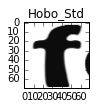

In [19]:
X_test, y_test, yStr = load_test('test_f') 
X_test = process_income_image(X_test)
print(X_test.shape, y_test.shape, yStr.shape)
print(y_test)
print(yStr)

In [20]:
# get top n classes predict results

topn = 15

rst = model.predict(X_test, verbose=1)
topncl = [numpy.zeros(topn)]
for eachc in rst:
    k = sorted(range(len(eachc)), key=lambda x: eachc[x], reverse=True)[:topn]
    topncl = numpy.concatenate((topncl, [k]), axis=0)
topncl = numpy.delete(topncl, 0, axis=0)
print("top n classes:", topncl)
rst1 = model.predict_classes(X_test[0:5], verbose=1)
probs = numpy.zeros((rst.shape[0], topn))
ncount = 0
#print("probs sizes:", probs.shape, probs[0][0], topncl.shape)
for prob in probs:
    for icount in range(0, topn):
        theno = int(topncl[ncount][icount])
        prob[icount] = float(rst[int(ncount)][theno])
        
    ncount+=1
print("top n probs:", probs)
rststr = numpy.zeros((rst.shape[0], topn), dtype=object)
for ncount in range(0,rststr.shape[0]):
    for icount in range(0, topn):
        thenumber = int(topncl[ncount][icount])
        thestr = encoder.inverse_transform(thenumber)
        rststr[ncount][icount] = thestr
print("top class str:",rststr)

25/25 [==============================] - 0s
top n classes: [[ 10.  20.   9.  38.  12.   2.  23.   4.   7.   0.  36.  33.  14.  13.
   35.]
 [  4.  30.  21.   8.   7.  16.   6.  27.   0.  13.  28.  10.  36.  12.
   33.]
 [ 21.  28.   6.  30.   7.   4.  36.  13.  26.   0.   8.  24.   5.  18.
   31.]
 [  4.  12.  13.  21.  30.   7.  10.  36.  16.   0.  38.  11.   6.  28.
   27.]
 [ 38.  11.  12.  10.  13.   4.  16.  27.  30.  33.  29.  36.   0.   1.
    2.]
 [  9.  20.   2.  10.   4.  12.  23.   0.  14.   7.  36.  21.  33.  38.
   30.]
 [ 20.   9.   2.  10.  23.   4.  12.   0.  14.  36.   7.  21.  38.  33.
   24.]
 [ 10.  20.  12.   9.   2.   4.  23.  38.   0.  36.  14.   7.  21.  35.
   37.]
 [ 10.  20.   4.  12.  23.   9.   2.   0.  36.  14.  16.  21.  35.  37.
   24.]
 [ 36.  21.   0.   4.  30.   2.   9.  12.  20.  10.  33.   7.  28.  24.
   13.]
 [ 35.  37.  25.   0.  24.  20.  23.  10.  36.   2.  14.   4.  21.  12.
   16.]
 [ 10.   9.  12.  20.   4.   2.  38.  23.   0.  36.   7.  14.

top class str: [['Hobo_std' 'Microsoft_Sans_Serif' 'Helvetica' 'Zapfino' 'Impact' 'Arial'
  'Myriad_Hebrew' 'Baskerville' 'Cochin' 'American_Typewriter' 'Times'
  'Snell_Roundhand' 'Kozuka_Gothic_Pro' 'Kai' 'Tahoma']
 ['Baskerville' 'Savoye_LET' 'Minion_Pro' 'Copperplate' 'Cochin'
  'Lithos_Pro' 'Chalkduster' 'Orator_Std' 'American_Typewriter' 'Kai'
  'Palatino' 'Hobo_std' 'Times' 'Impact' 'Snell_Roundhand']
 ['Minion_Pro' 'Palatino' 'Chalkduster' 'Savoye_LET' 'Cochin' 'Baskerville'
  'Times' 'Kai' 'Optima' 'American_Typewriter' 'Copperplate' 'Nueva_Std'
  'Brush Script Std' 'Luminari' 'SignPainter']
 ['Baskerville' 'Impact' 'Kai' 'Minion_Pro' 'Savoye_LET' 'Cochin'
  'Hobo_std' 'Times' 'Lithos_Pro' 'American_Typewriter' 'Zapfino'
  'Hoefler_Text' 'Chalkduster' 'Palatino' 'Orator_Std']
 ['Zapfino' 'Hoefler_Text' 'Impact' 'Hobo_std' 'Kai' 'Baskerville'
  'Lithos_Pro' 'Orator_Std' 'Savoye_LET' 'Snell_Roundhand'
  'Prestige_Elite_Std' 'Times' 'American_Typewriter' 'Andale_Mono' 'Arial']
 [

In [21]:
print (rststr.shape, probs.shape)
print (rststr[0:,0])
print (y_test)

rst_df = pd.DataFrame({"id": list(range(1,0+len(rst)+1)),
                       "label": y_test,
                       "filename": yStr,
                       "p1":rststr[0:,0],
                       "p1prob":probs[0:,0],
                       "p2":rststr[0:,1],
                       "p2prob":probs[0:,1],
                       "p3":rststr[0:,2],
                       "p3prob":probs[0:,2],
                       "p4":rststr[0:,3],
                       "p4prob":probs[0:,3],
                       "p5":rststr[0:,4],
                       "p5prob":probs[0:,4],
                       "p6":rststr[0:,5],
                       "p6prob":probs[0:,5],
                       "p7":rststr[0:,6],
                       "p7prob":probs[0:,6],
                       "p8":rststr[0:,7],
                       "p8prob":probs[0:,7],
                       "p9":rststr[0:,8],
                       "p9prob":probs[0:,8],
                       "p10":rststr[0:,9],
                       "p10prob":probs[0:,9],
                       "p11":rststr[0:,10],
                       "p11prob":probs[0:,10],
                       "p12":rststr[0:,11],
                       "p12prob":probs[0:,11],
                       "p13":rststr[0:,12],
                       "p13prob":probs[0:,12]
                      })
rst_df.to_csv('rstpreditct0811_best5_f1_5389.csv', index=False, header=True)

(25, 15) (25, 15)
['Hobo_std' 'Baskerville' 'Minion_Pro' 'Baskerville' 'Zapfino' 'Helvetica'
 'Microsoft_Sans_Serif' 'Hobo_std' 'Hobo_std' 'Times' 'Tahoma' 'Hobo_std'
 'Minion_Pro' 'Zapfino' 'Hobo_std' 'Zapfino' 'Times' 'Baskerville'
 'Baskerville' 'American_Typewriter' 'Andale_Mono' 'Cochin' 'Hobo_std'
 'Andale_Mono' 'Baskerville']
['Hobo_Std' 'Cochin' 'Baskerville' 'Baskerville' 'Zapfino' 'Helvetica'
 'Helvetica' 'Hobo_Std' 'Baskerville' 'Amenrican_Typewriter' 'Helvetica'
 'Hobo_Std' 'Baskerville' 'Zapfino' 'Hobo_Std' 'Zapfino' 'Andale_Mono'
 'Baskerville' 'Andale_Mono' 'Amenrican_Typewriter' 'Andale_Mono' 'Cochin'
 'Helvetica' 'Andale_Mono' 'Helvetica']


In [28]:
from keras.models import load_model

# try to load the file to check if saving works
model_L = load_model('my_model_0809.h5')
# model_L.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# score = model_L.evaluate(X_test, Y_test, verbose=0)
# print("%s: %.2f%%" % (model_L.metrics_names[1], score[1]*100))